In [1]:
import numpy as np
from data_scripts import load_data as load_data_
from thermal_solvers import make_thermal_solver_space
from matplotlib import pyplot as plt

N_NEWEST = 1


def load_data(path):
    return load_data_(path, n_newest=1)[0]

np.random.seed(42)

# data_m = only_cpr("examples/2/thermal_warmstart_m_s_stacking.py")
# data_m = only_cpr("examples/2/thermal_warmstart_m_s_stacking")
# data_l = load_data('examples/2/thermal_warmstart_l_sm_stacking')

In [2]:
from data_scripts import get_newest_data_paths
from solver_selector.solver_selector import make_solver_selector 
from solver_selector.performance_predictor import make_performance_predictor, train_performance_predictor
from thermal_solvers import make_thermal_solver_space

solver_space = make_thermal_solver_space(solver='dynamic')

In [3]:
# from sklearn.metrics import explained_variance_score


# def compare(div):
#     # data_train, data_test = data_m[:div], data_m[div:]
#     data_train, data_test = data_l[:div], data_l[div:]

#     stacking = make_solver_selector(
#         params={
#             "print_solver": True,
#             "regressor": "stacking",
#             "samples_before_fit": 0,
#             'exploration': 0,
#             "stacking_datasets": [
#                 get_newest_data_paths("examples/1/thermal_dynamic", n_newest=1),
#                 get_newest_data_paths(
#                     "examples/2/thermal_warmstart_m_s_stacking", n_newest=1
#                 ),
#             ],
#         },
#         solver_space=solver_space,
#     )

#     baseline = make_solver_selector(
#         params={
#             "print_solver": True,
#             "samples_before_fit": 0,
#             'exploration': 0,
#             "load_statistics_paths": (
#                 get_newest_data_paths("examples/1/thermal_dynamic", n_newest=1)
#                 + get_newest_data_paths("examples/2/thermal_warmstart_m_s_stacking", n_newest=1)
#             ),
#         },
#         solver_space=solver_space,
#     )

#     stacking.learn_performance_offline(data_train)
#     baseline.learn_performance_offline(data_train)

#     stacking_predictions = []
#     baseline_predictions = []
#     true_targets = []

#     for entry in data_test:
#         stacking_predictions.append(stacking.select_solver(entry.prediction.context).score)
#         baseline_predictions.append(baseline.select_solver(entry.prediction.context).score)
#         true_targets.append(entry.rewards[0])
#     b_score = explained_variance_score(y_pred=baseline_predictions, y_true=true_targets)
#     s_score = explained_variance_score(y_pred=stacking_predictions, y_true=true_targets)
#     return b_score, s_score

#     return None, None, None
#     # stacking_prediction.decision.subsolvers.values()

#     # baseline_score = baseline.regressor.score(full_contexts, rewards)
#     # stacking_score = stacking.regressor.score(full_contexts, rewards)
#     # coefs = list(stacking.regressor.trust_model.coef_) + [
#     #     stacking.regressor.trust_model.intercept_
#     # ]
#     return baseline_score, stacking_score, coefs

In [4]:
# from tqdm import tqdm

# b_list = []
# s_list = []
# x_list = np.arange(5, 20)
# for i in tqdm(x_list):
#     baseline, stacking = compare(div=i)
#     b_list.append(baseline)
#     s_list.append(stacking)


In [5]:
# plt.plot(x_list, b_list, label="baseline")
# plt.plot(x_list, s_list, label="stacking")
# plt.title("accuracy")
# # plt.ylim(0, 1)
# plt.legend()

In [6]:
from typing import Sequence
from data_scripts import make_simulation_time, make_solve_linear_system_time, sum_per_time_step
from solver_selector.data_structures import SolverSelectionData

CONVERGED = False

data_cpr = load_data('examples/1/thermal_cpr')
data_schur = load_data('examples/1/thermal_schur.py')

cpr_time = make_simulation_time(data_cpr, converged=CONVERGED)
schur_time = make_simulation_time(data_schur, converged=CONVERGED)
assert np.all((cpr_time == schur_time)[:-22])
cpr_time = cpr_time[:-22]
schur_time = schur_time[:-22]

cpr_runtime = sum_per_time_step(make_solve_linear_system_time(data_cpr, converged=CONVERGED), data_cpr, converged=CONVERGED)
schur_runtime = sum_per_time_step(make_solve_linear_system_time(data_schur, converged=CONVERGED), data_cpr, converged=CONVERGED)

select_schur = schur_runtime < cpr_runtime

data_best: Sequence[SolverSelectionData]
data_best = np.where(select_schur, data_schur, data_cpr)

Loading data:
/home/firedrake/solver_selector/examples/1/performance/thermal_cpr_26.npy


/home/firedrake/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Loading data:
/home/firedrake/solver_selector/examples/1/performance/thermal_schur_19.npy


In [7]:
data_to_distort = load_data('examples/1/thermal_dynamic.py')
for entry in data_to_distort:
    rewards = entry.rewards
    # noise = np.random.random(len(rewards))
    # noise = -1 + noise * 2
    # noise *= 1 * (max(rewards) - min(rewards))
    # entry.rewards[:] += noise
    if 'cpr' in entry.config['gmres']['preconditioner']:
    # if np.random.random() > 0.5:
        entry.rewards[:] += 100
    else:
        entry.rewards[:] -= 100
    # entry.rewards[:] /= 10

np.save('distorted_data.npy', data_to_distort)

Loading data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy


In [8]:
stacking = make_solver_selector(
    params={
        "print_solver": True,
        "regressor": "stacking",
        "samples_before_fit": 0,
        "exploration": 0,
        "stacking_datasets": [
            get_newest_data_paths("examples/2/thermal_warmstart_l_sm", n_newest=1),
            get_newest_data_paths("examples/2/thermal_warmstart_m_s", n_newest=1),
            # get_newest_data_paths("examples/1/thermal_random.py")
            # ['distorted_data.npy']
        ],
    },
    solver_space=solver_space,
)

baseline = make_solver_selector(
    params={
        "print_solver": True,
        "samples_before_fit": 0,
        "exploration": 0,
        "load_statistics_paths": (
            get_newest_data_paths("examples/2/thermal_warmstart_l_sm", n_newest=1)
            + 
            get_newest_data_paths("examples/2/thermal_warmstart_m_s", n_newest=1)
            # +
            # get_newest_data_paths("examples/1/thermal_random.py")
            # +
            # ['distorted_data.npy']
        ),
    },
    solver_space=solver_space,
)

Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, primary_variable, method]
1 gmres - cpr [primary - amg, secondary - ilu, primary_variable]
Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_l_sm_5.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_15.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_l_sm_5.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/

In [9]:
from tqdm import tqdm

b_successes = []
s_successes = []

for time_step in tqdm(data_best[:]):
    s_pred = stacking.select_solver(time_step.prediction.context)
    b_pred = baseline.select_solver(time_step.prediction.context)
    s_config = solver_space.config_from_decision(s_pred.decision)
    b_config = solver_space.config_from_decision(b_pred.decision)
    true = time_step.config

    b_successes.append(b_config == true)
    s_successes.append(s_config == true)

    true_decision = solver_space.decision_from_config(true)

    time_step.prediction.decision.subsolvers.clear()
    time_step.prediction.decision.subsolvers.update(true_decision.subsolvers)
    stacking.learn_performance_online(time_step)

    time_step.prediction.decision.subsolvers.clear()
    time_step.prediction.decision.subsolvers.update(true_decision.subsolvers)
    baseline.learn_performance_online(time_step)

  0%|          | 0/230 [00:00<?, ?it/s]

100%|██████████| 230/230 [01:08<00:00,  3.34it/s]


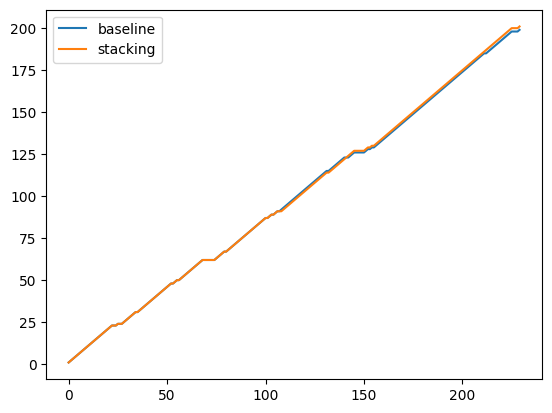

In [10]:
plt.plot(np.cumsum(b_successes), label='baseline')
plt.plot(np.cumsum(s_successes), label='stacking')
plt.legend()

In [11]:
stacking.predictors[0].regressor.trust_model.coef_

array([ 0.00929072, -0.00285708,  1.00718767])

In [12]:
stacking.predictors[1].regressor.trust_model.coef_

array([ 0.0135715 , -0.00259131,  1.00172112])